In [1]:
import numpy as np
import geopandas
import torch
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

from manifm.eval_utils import load_model
from manifm.datasets import get_loaders, get_manifold
from manifm.model_pl import ManifoldAELitModule
from manifm.utils import lonlat_from_cartesian

In [2]:
device = "cpu"
seed = 0
flow_ckpt_path = "/home/yjang43/workspace/riemannian-fm/outputs/multiruns/fire/fm/2024.11.19/231101/1/checkpoints/last.ckpt"
reflow_ckpt_path = "/home/yjang43/workspace/riemannian-fm/outputs/runs/reflow_fire/fm/2024.11.21/223550/checkpoints/last.ckpt"

In [3]:
def sample_path(ckpt_path, num_steps_list=[1000, 100, 10, 1]):
    cfg, pl_model = load_model(ckpt_path)
    pl_model.train(mode=False)
    pl_model.to(device)
    manifold, dim = get_manifold(cfg)

    torch.manual_seed(seed)
    x0 = manifold.random_base(1, dim)

    x_t_dict = {}
    for num_steps in num_steps_list:
        x_t = pl_model.sample_all(None, device, x0.to(device), num_steps=num_steps).cpu()
        x_t_dict[num_steps] = x_t

    return x_t_dict

flow_x_t_dict = sample_path(flow_ckpt_path)
reflow_x_t_dict = sample_path(reflow_ckpt_path)


/home/yjang43/workspace/riemannian-fm/manifm/eval_utils.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpnt = torch.load(checkpoint, map_location="cpu")
/home/yjang4

In [4]:

def plot_earth2d(ax, samples, color="red", zoom=False):

    # set x axis and y axis label
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Plot model samples
    geometry = [Point(lonlat_from_cartesian(x) / np.pi * 180) for x in samples]
    pts = geopandas.GeoDataFrame(geometry=geometry)
    pts[-1:].plot(ax=ax, color="black", markersize=3, alpha=0.7, label="_nolegend_")
    pts[:1].plot(ax=ax, color="black", markersize=3, alpha=0.7, label="_nolegend_")
    if zoom:
        # set max of x and y to be lim
        minx, miny, maxx, maxy = pts.total_bounds
        if ax.get_xlim()[1] - ax.get_xlim()[0] < 150:
            minx, maxx = min(minx, ax.get_xlim()[0]), max(maxx, ax.get_xlim()[1])
            miny, maxy = min(miny, ax.get_ylim()[0]), max(maxy, ax.get_ylim()[1])
        ax.set_xlim(minx-5, maxx+5)
        ax.set_ylim(miny-5, maxy+5)
    
    # Create LineStrings between consecutive points
    lines = [
        LineString([geometry[i], geometry[i + 1]]) for i in range(len(geometry) - 1)
    ]
    line_gdf = geopandas.GeoDataFrame(geometry=lines)

    # Plot lines connecting points
    line_gdf.plot(ax=ax, color=color, linewidth=1, alpha=0.5)
    return ax

/tmp/ipykernel_669916/962112068.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


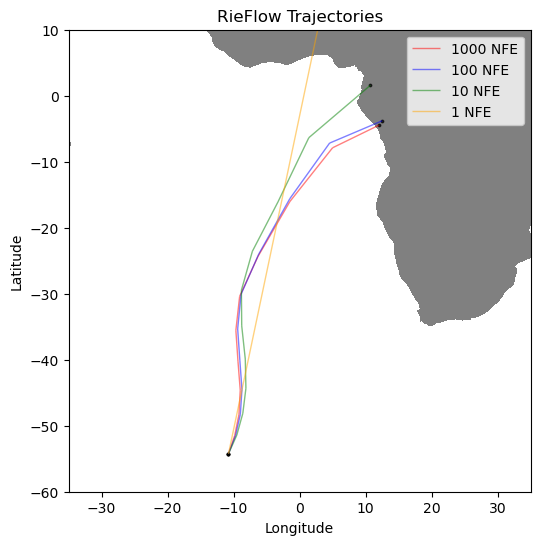

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
ax = world.plot(figsize=(6, 6), antialiased=False, color="grey")

plot_earth2d(ax, flow_x_t_dict[1000][::100], "red", zoom=True)
plot_earth2d(ax, flow_x_t_dict[100][::10], "blue", zoom=True)
plot_earth2d(ax, flow_x_t_dict[10], "green", zoom=True)
plot_earth2d(ax, flow_x_t_dict[1], "orange", zoom=True)
ax.set_xlim(-35, 35)
ax.set_ylim(-60, 10)

ax.set_title("RieFlow Trajectories")
ax.legend(["1000 NFE", "100 NFE", "10 NFE", "1 NFE"])

fig = ax.get_figure()
fig.savefig("figs/rieflow_trajectory.png")

/tmp/ipykernel_669916/3763107865.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


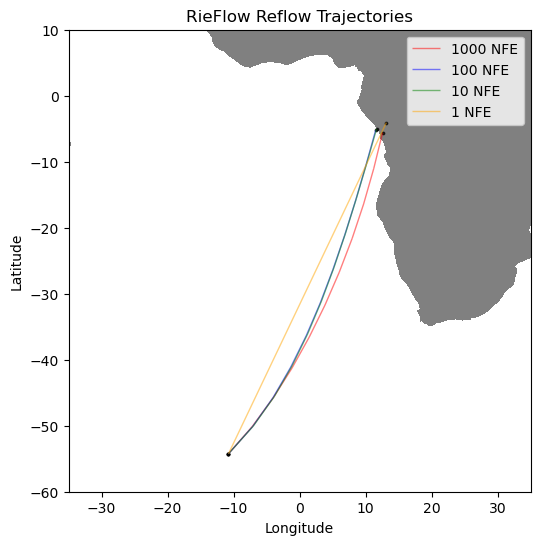

In [6]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
ax = world.plot(figsize=(6, 6), antialiased=False, color="grey")

plot_earth2d(ax, reflow_x_t_dict[1000][::100], "red", zoom=True)
plot_earth2d(ax, reflow_x_t_dict[100][::10], "blue", zoom=True)
plot_earth2d(ax, reflow_x_t_dict[10], "green", zoom=True)
plot_earth2d(ax, reflow_x_t_dict[1], "orange", zoom=True)
ax.set_xlim(-35, 35)
ax.set_ylim(-60, 10)

ax.set_title("RieFlow Reflow Trajectories")
ax.legend(["1000 NFE", "100 NFE", "10 NFE", "1 NFE"])

fig = ax.get_figure()
fig.savefig("figs/rieflow_reflow_trajectory.png")